In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import OneHotEncoder
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_final.parquet")

In [3]:
# For "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [4]:
# For "day_of_week" : 

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["day_of_week"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [5]:
# Selecting only the needed features
df_cct = df_cct[['Card', 'Month', 'Day', 'Hours', 'Amount', 'delta_t_s', 'delta_t_s_card', 'amt/daily_income',
       'Retired', 'daily_amount', 'nb_daily_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt',
       'Chip Transaction', 'Online Transaction',
       'Swipe Transaction', 'day_of_week_Friday', 'day_of_week_Monday',
       'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday', 'day_of_week_Wednesday','Is Fraud?']]

In [6]:

# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('std', RobustScaler(), ['Card', 'Month', 'Day', 'Hours', 'Amount',
       'delta_t_s', 'delta_t_s_card', 'amt/daily_income',
       'daily_amount', 'nb_daily_declines_card', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt',])
        ])

preprocessor.fit_transform(df_cct)

array([[-0.5       ,  0.28571429, -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.5       ,  0.28571429, -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.5       ,  0.28571429, -0.93333333, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , -0.71428571,  0.8       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.71428571,  0.8       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.71428571,  0.8       , ...,  0.        ,
         0.        ,  0.        ]])

In [7]:
df_cct[['Card', 'Month', 'Day', 'Hours', 'Amount',
       'delta_t_s', 'delta_t_s_card', 'amt/daily_income',
       'daily_amount', 'nb_daily_declines_card', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt', 'Retired',
       'bad_pin', 'insufficient_balance', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
        'Is Fraud?']] = preprocessor.fit_transform(df_cct)

In [8]:
!pip install imbalanced-learn

In [9]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [10]:
over = SMOTE(sampling_strategy = 0.5)
under = RandomUnderSampler(sampling_strategy = 0.1)
f1 = df_cct.iloc[:,:25].values
t1 = df_cct.iloc[:,25].values

steps = [('under', under),('over', over)]
pipeline = Pipeline(steps=steps)
f1, t1 = pipeline.fit_resample(f1, t1)
Counter(t1)

Counter({0.0: 297570, 1.0: 148785})

In [11]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(f1, t1, test_size = 0.20, random_state = 2)


In [26]:
def model(classifier,x_train,y_train,x_test,y_test):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))

    

In [21]:
def model_evaluation(classifier,x_test,y_test):
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    
    # Classification Report
    print(classification_report(y_test,classifier.predict(x_test)))

In [14]:
from sklearn.linear_model import LogisticRegression

In [23]:
classifier_lr = LogisticRegression() 

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve

Cross Validation Score :  85.11%
ROC_AUC Score :  77.29%
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86     59459
         1.0       0.75      0.65      0.70     29812

    accuracy                           0.81     89271
   macro avg       0.80      0.77      0.78     89271
weighted avg       0.81      0.81      0.81     89271



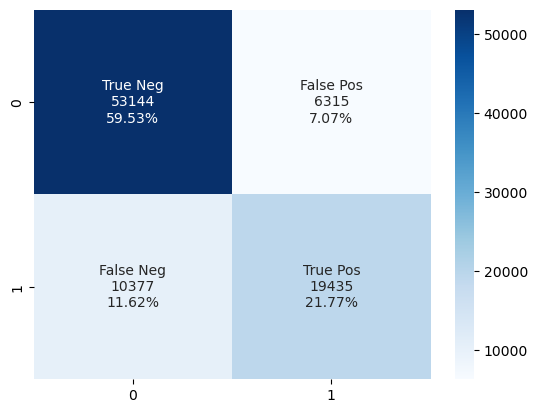

In [27]:
model(classifier_lr,x_train1,y_train1,x_test1,y_test1)
model_evaluation(classifier_lr,x_test1,y_test1)

In [30]:
X1 = df_cct.iloc[:,:25]
y = df_cct.iloc[:,25]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.20, random_state = 2, stratify=y)


              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94   4871429
         1.0       0.01      0.63      0.01      5951

    accuracy                           0.89   4877380
   macro avg       0.50      0.76      0.48   4877380
weighted avg       1.00      0.89      0.94   4877380



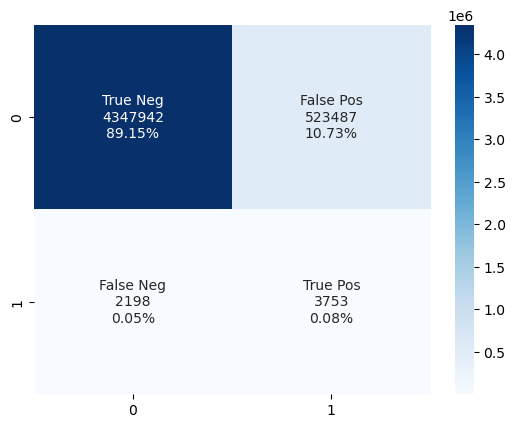

In [33]:
model_evaluation(classifier_lr,X_test,y_test)